In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/preds/tbl__mini__euclidean.csv', delimiter=',').values

In [ ]:
attr_id = data[:,0].astype(int)
correct_value_id = data[:,1].astype(int)
rank = data[:,2].astype(int)
scores = data[:,3:]
preds = np.argsort(scores, axis=-1)

In [ ]:
import utils

with open('./data/mini/attr.txt', 'r') as f:
    attr_vocab = utils.Vocab.load(f)
    
with open('./data/mini/desc.txt', 'r') as f:
    desc_vocab = utils.Vocab.load(f)
    
with open('./data/mini/value.txt', 'r') as f:
    value_set = utils.ValueSet.load(f)

In [ ]:
from sklearn import metrics

# Identify unk and non-unk data points
unk = correct_value_id == len(value_set)
non_unk = correct_value_id != len(value_set)

# Metrics at 1
precision_at_1 = metrics.precision_score(correct_value_id[non_unk], preds[non_unk,:1], average=None)
recall_at_1 = metrics.recall_score(correct_value_id[non_unk], preds[non_unk,:1], average=None)
f1_at_1 = metrics.f1_score(correct_value_id[non_unk], preds[non_unk,:1], average=None)

hstring = '{0:16.16}\t{1:.6}\t{2:.6}\t{3:.6}'
fstring = '{0:16.16}\t{1:0.4f}\t{2:0.4f}\t{3:0.4f}'
print(hstring.format('', 'prec', 'rec', 'f1'))
for i, value in enumerate(value_set.global_vocab._id2word):
    print(fstring.format(value, precision_at_1[i], recall_at_1[i], f1_at_1[i]))



In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

# Confusion matrix at 1
plt.figure(figsize=(16,16))
confusion_matrix = metrics.confusion_matrix(correct_value_id[non_unk], preds[non_unk,:1])
plt.imshow(confusion_matrix[:100,:100])
plt.xticks(range(100), value_set.global_vocab._id2word[:100], rotation=90)
plt.yticks(range(100), value_set.global_vocab._id2word[:100]);

In [ ]:
# View UNK accuracy as a function of k

def unk_acc(rank, max_k=20):
    out = []
    for k in range(1, max_k+1):
        acc = np.mean(rank <= k)
        out.append(acc)
    return out

plt.figure(figsize=(16,8))
plt.plot(unk_acc(rank[unk]))
plt.xticks(range(20), range(1, 21));
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy@k of <UNK> predictions');

In [ ]:
# Accuracy at K for top 10 most common categories

def top10acc(attr_id, rank, max_k=20):
    out = []
    for i in range(10):
        idx = attr_id == i
        sub = []
        for k in range(1, max_k+1):
            acc = np.mean(rank[idx] <= k)
            sub.append(acc)
        out.append(sub)
    return out

acc = top10acc(attr_id, rank)
plt.figure(figsize=(16,8))
for i, series in enumerate(acc):
    plt.plot(series, label=attr_vocab.id2word(i))
plt.legend()
plt.xticks(range(20), range(1, 21));
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy@k of Most Common Attributes');

In [ ]:
nunk = attr_id[non_unk]
y_true = np.expand_dims(correct_value_id[non_unk], 1)
y_pred = preds[non_unk]

attr0 = nunk == 0
y_true0 = y_true[attr0]
y_pred0 = y_pred[attr0]

np.sum(y_pred[:,:100] == y_true) / y_pred.shape[0]

In [ ]:
print(attr_id[non_unk])
print(scores[non_unk])

# MATE Analysis


In [1]:
import json
from utils import Vocab, ValueSet

with open('data/mini/attr.txt', 'r') as f:
    attr_vocab = Vocab.load(f)
    
with open('data/mini/value.txt', 'r') as f:
    value_vocab = ValueSet.load(f)

with open('data/preds/mate.json', 'r') as f:
    mate_data = json.load(f)

In [36]:
import numpy as np

def view_results(x):
    preds = x[0]
    product = x[1][0]
    print('===True Attrs===')
    for attr in product['specs']:
        print(attr)
    print('===Predictions===')
    attr_ids = [x[0] for x in preds]
    scores = [x[1] for x in preds]
    scores = np.cumsum([np.log(x) for x in scores])
    for attr_id, score in zip(attr_ids, scores):
        print(attr_vocab.id2word(attr_id), score)
    print(product['text'])

view_results(mate_data[4])

===True Attrs===
package_quantity
platform
===Predictions===
warranty -0.016308002472766564
color -0.0246788887757515
number_of_pieces -0.026339063367381142
colour -0.02742970764734401
package_quantity -0.028161503149697203
assembly_required -0.028304206850978342
format -0.02839910194785805
batteries_included -0.028493520162441607
frame_material -0.028585196308235597
packaged_quantity -0.028670196144069
color_finish -0.02874875815179668
aspect_ratio -0.028821597680446266
paperback -0.02889086067630119
shipping -0.02896000445461659
colors -0.029029029015406677
quantity -0.029098053576196766
availability -0.029167078136986855
pattern -0.029238487050983586
size -0.02931454547008521
shape -0.21056467499007409
platform -0.2109067449410505
weight -0.21097684246008003
age -0.2110523047875755
movement -0.21113420492322144
number_of_discs -0.21122755015347014
hardcover -0.2283592371096615
binding -0.22846235846194682
care -0.22856166473084694
assembly -0.2286812387969601
finish -0.2371137353225

In [14]:
import numpy as np

logscore_range = [0, *-np.logspace(-4, 4, num=25), -float('inf')]

def evaluate(x):
    precision = np.zeros(len(logscore_range))
    recall = np.zeros(len(logscore_range))
    attrs, scores = zip(*x[0])
    attrs = np.array(attrs)
    logscores = np.cumsum([np.log10(s) for s in scores])
    product = x[1][0]
    correct_attrs = [attr_vocab.word2id(w) for w in product['specs']]
    for i, cutoff in enumerate(logscore_range):
        idx = logscores > cutoff
        predicted_attrs = attrs[idx]
        tp = len([attr for attr in predicted_attrs if attr in correct_attrs])
        try:
            precision[i] = tp / len(predicted_attrs)
        except ZeroDivisionError:
            precision[i] = 0
        try:
            recall[i] = tp / len(correct_attrs)
        except ZeroDivisionError:
            recall[i] = 0
    return precision, recall

        
precisions = []
recalls = []
for x in mate_data:
    precision, recall = evaluate(x)
    precisions.append(precision)
    recalls.append(recall)

In [19]:
precision_mat = np.array(precisions)
macro_precision = np.mean(precision_mat, axis=0)

recall_mat = np.array(recalls)
macro_recall = np.mean(recall_mat, axis=0)

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

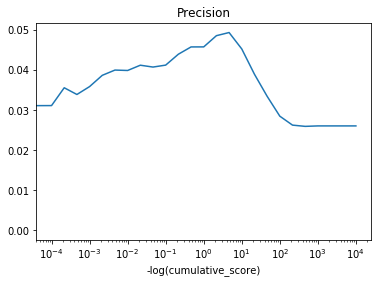

In [35]:
plt.semilogx(-1*np.array(logscore_range), macro_precision)
plt.title('Precision')
plt.xlabel('-log(cumulative_score)');

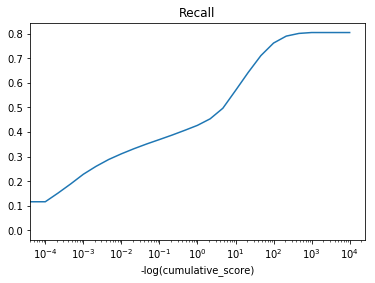

In [34]:
plt.semilogx(-1*np.array(logscore_range), macro_recall)
plt.title('Recall')
plt.xlabel('-log(cumulative_score)');

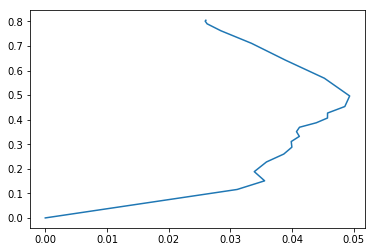

In [37]:
plt.plot(macro_precision, macro_recall)